In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm
import copy

In [3]:
emb_dim=50

# Terms

* variable
* function
* predicate
* clause

In [4]:
class Predicate:
    def __init__(self, name, variables, negation):
        self.name=name
        self.variables=variables
        self.negation=negation
    
    def show(self):
        s=''
        if self.negation:
            s+='¬'
        s='%s%s(%s)'%(s,self.name,', '.join(self.variables))
        return s

In [5]:
class Clause:
    def __init__(self, v,w,predicates, weight=1.0):
        self.v=float(v)
        self.w=float(w)
        self.predicates=predicates
        self.weight=weight
    def show(self):
        ss=[]
        for p in self.predicates:
            ss.append(p.show())
        ss=' ∨ '.join(ss)
#         ss='%0.2f: '%(self.weight)+ss
        return ss

In [6]:
class KnowledgeBase:
    def __init__(self,clauses):
        self.clauses=clauses
    def show(self):
        for i,c in enumerate(self.clauses):
            print(c.show())
    def union(self, knowledge_base):
        new_knowledge_base=copy.deepcopy(self)
        for clause in knowledge_base.clauses:
            new_knowledge_base.clauses.append(clause)
        return new_knowledge_base

In [69]:
class Propositional:
    def __init__(self, v, w, conditions, clause):
        self.v = v
        self.w = w
        self.conditions = conditions
        self.clause = clause

    def generate_knowledge_base(self,constants):
        self.knowledge_base = KnowledgeBase([self.clause])
        for condition in self.conditions:
            new_knowledge_base = self.bound_knowledge_base(
                self.knowledge_base, condition[1], constants, condition[0])
            self.knowledge_base = new_knowledge_base
        return self.knowledge_base

    def bound_knowledge_base(self, knowledge_base, variable, constants,
                             existential):
        clauses = []
        for clause in knowledge_base.clauses:
            clauses += self.bound_clause_variable_with_constants(
                clause, variable, constants, existential)
        for i in range(len(clauses)):
            clauses[i].weight=1.0/len(clauses)
        return KnowledgeBase(clauses=clauses)

    def bound_clause_variable_with_constants(self, clause, variable, constants,
                                             existential):
        clauses = []
        for constant in constants:
            clauses.append(
                self.bound_clause_variable_with_constant(
                    clause, variable, constant))
        if existential:
            all_predicates = []
            for clause in clauses:
                all_predicates += clause.predicates
            return [Clause(clauses[0].v, clauses[0].w, all_predicates)]
        else:
            return clauses

    def bound_clause_variable_with_constant(self, clause, variable, constant):
        new_clause = copy.deepcopy(clause)
        for i in range(len(clause.predicates)):
            for j in range(len(new_clause.predicates[i].variables)):
                if new_clause.predicates[i].variables[j] == variable:
                    new_clause.predicates[i].variables[j] = constant
        return new_clause

In [70]:
def load_knowledge_base(filename):
    clauses=[]
    for line in open(filename):
        line=line.strip().split('|')
        v,w=line[0].split(',')
        line=line[1].strip().split(',')
        if line[0]=='not':
            negation=True
            line=line[1:]
        else:
            negation=False
        predicate=Predicate(name=line[0],negation=negation,variables=line[1:])
        clauses.append(Clause(v=v,w=w,predicates=[predicate]))
    return KnowledgeBase(clauses)

In [71]:
def load_propositional(filename):
    propositionals=[]
    for line in open(filename):
        line=line.strip().split('|')
        condition=[]
        v,w=line[0].split(',')
        for c in line[1].strip().split(','):
            c=c.strip().split(' ')
            if c[0]=='all':
                c[0]=False
            else:
                c[0]=True
            condition.append(c)
        predicates=[]
        for predicate in line[2:]:
            predicate=predicate.strip().split(',')
            if predicate[0]=='not':
                predicate=Predicate(name=predicate[1],negation=True,variables=predicate[2:])
            else:
                predicate=Predicate(name=predicate[0],negation=False,variables=predicate[1:])
            predicates.append(predicate)
        propositionals.append(Propositional(v,w,condition,Clause(v,w,predicates)))
    return propositionals

In [72]:
def show_results(model, knowledge_base):
    wrong=0
    for clause in knowledge_base.clauses:
        output=model.forward(clause=clause)
        if output[0].data.numpy()[0]<0.1:
            continue
        print(clause.show())
        print(output[0].data.numpy()[0], output[1].data.numpy()[0])
        wrong+=1
    print(wrong)

In [73]:
class GConstants(nn.Module):
    def __init__(self, constants,emb_dim):
        super(GConstants, self).__init__()
        self.symbol2id=dict()
        self.id2symbol=dict()
        for i,s in enumerate(constants):
            self.symbol2id[s]=i
            self.id2symbol[i]=s
        self.embeddings = nn.Embedding(len(self.symbol2id), emb_dim)
#         initrange=0.5/emb_dim
#         self.embeddings.weight.data.uniform_(-initrange, initrange)
    def forward(self,constants):
        constant_id=[]
        for c in constants:
            constant_id.append(self.symbol2id[c])
        embs=self.embeddings(Variable(torch.LongTensor(constant_id)))
        embs=torch.cat(embs).view(1,-1)
        return embs

In [74]:
class GPredicate(nn.Module):
    def __init__(self, name, variable_count, emb_dim):
        super(GPredicate, self).__init__()
        self.name=name
        self.variable_count=variable_count
        self.emb_dim=emb_dim
        m=variable_count*emb_dim
        self.variable_count=variable_count
        self.bilinear=nn.Bilinear(m,m,emb_dim,bias=False)
        self.linear1=nn.Linear(m,emb_dim,bias=True)
        self.linear2=nn.Linear(emb_dim,1,bias=False)
        self.activation1=nn.Tanh()
        self.activation2=nn.Sigmoid()
#         self.W=nn.Parameter(torch.randn(m, emb_dim, m))
#         self.V=nn.Parameter(torch.randn(m, emb_dim))
#         self.B=nn.Parameter(torch.randn(emb_dim))
#         self.u=nn.Parameter(torch.randn(emb_dim))
    def forward(self, embs, negation):
        embs=embs.view(1,-1)
        output=self.bilinear(embs,embs)+self.linear1(embs)
        output=self.activation1(output)
        output=self.linear2(output)
        output=self.activation2(output)
        if negation:
            output=1.0-output
        return output
#         m=self.variable_count*self.emb_dim
#         W=self.W.view(m,-1)
#         output=torch.mm(embs,W)
#         output=output.view(-1,m)
#         output=torch.mm(output,embs.view(-1,1))
#         output=output.view(1,-1)
#         output=output.add(torch.mm(embs,self.V))
#         output=output.add(self.B)
#         output=output.view(-1)
#         output=torch.tanh(output)
#         output=torch.mul(output,self.u).sum()
#         output=torch.sigmoid(output)
#         if negation:
#             output=1.0-output
#         return output

In [75]:
class LTN(nn.Module):
    def __init__(self, emb_dim, constants, predicates):
        super(LTN, self).__init__()
        self.emb_dim=emb_dim
        self.Constants=GConstants(constants, emb_dim)
        self.Predicates=dict()
        for name,n in predicates:
            self.Predicates[name]=GPredicate(name,n,emb_dim)
    def forward(self, clause):
        Phi=None
        v=Variable(torch.FloatTensor([clause.v]))
        w=Variable(torch.FloatTensor([clause.w]))
        for predicate in clause.predicates:
            negation=predicate.negation
            name=predicate.name
            constants=predicate.variables
            embs=self.Constants.forward(constants)
            output=self.Predicates[name].forward(embs,negation)
            if Phi is None or Phi.data.numpy()[0]<output.data.numpy()[0]:
                Phi=output
        if (Phi>w).data.all():
            loss=Phi-w
        elif (Phi<v).data.all():
            loss=v-Phi
        else:
            loss=Variable(torch.FloatTensor([0]),requires_grad=True)
        loss=loss*clause.weight
        return loss,Phi
    def parameters(self):
        results=list(self.Constants.parameters())
        for name in self.Predicates:
            results+=list(self.Predicates[name].parameters())
        return results

In [76]:
kb1=load_knowledge_base('./facts1.txt')
kb2=load_knowledge_base('./facts2.txt')
propositionals=load_propositional('./knowledge.txt')
gkbs1=[]
for p in propositionals:
    gkbs1.append(p.generate_knowledge_base('abcdefgh'))
gkb1=gkbs1[0]
for tkb in gkbs1[1:]:
    gkb1=gkb1.union(tkb)
gkbs2=[]
for p in propositionals:
    gkbs2.append(p.generate_knowledge_base('ijklmn'))
gkb2=gkbs2[0]
for tkb in gkbs2[1:]:
    gkb2=gkb2.union(tkb)

  0%|          | 0/2000 [00:00<?, ?it/s]

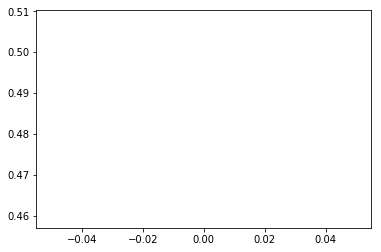

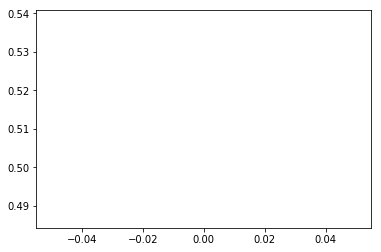

  0%|          | 1/2000 [00:01<57:05,  1.71s/it]

S(a)
[ 0.45310092] [ 0.54689908]
F(a, b)
[ 0.34435254] [ 0.65564746]
F(a, e)
[ 0.48655856] [ 0.51344144]
F(a, f)
[ 0.60869479] [ 0.39130518]
F(a, g)
[ 0.76279169] [ 0.23720831]
F(b, c)
[ 0.60452592] [ 0.39547411]
F(c, d)
[ 0.87017655] [ 0.12982346]
F(e, f)
[ 0.78551084] [ 0.21448918]
F(g, h)
[ 0.83295363] [ 0.16704638]
¬F(a, c)
[ 0.58020431] [ 0.41979569]
¬F(a, d)
[ 0.34049886] [ 0.65950114]
¬F(a, h)
[ 0.39310241] [ 0.60689759]
¬F(b, d)
[ 0.11584246] [ 0.88415754]
¬F(b, f)
[ 0.25089931] [ 0.74910069]
¬F(b, g)
[ 0.19622934] [ 0.80377066]
¬F(b, h)
[ 0.18488193] [ 0.81511807]
¬F(c, e)
[ 0.22728491] [ 0.77271509]
¬F(c, f)
[ 0.17374444] [ 0.82625556]
¬F(c, g)
[ 0.14083052] [ 0.85916948]
¬F(c, h)
[ 0.11496156] [ 0.88503844]
¬F(d, e)
[ 0.22874904] [ 0.77125096]
¬F(d, f)
[ 0.12364519] [ 0.87635481]
¬F(d, g)
[ 0.21299624] [ 0.78700376]
¬F(e, g)
[ 0.22805524] [ 0.77194476]
¬F(e, h)
[ 0.22172362] [ 0.77827638]
¬F(f, g)
[ 0.16027814] [ 0.83972186]
¬F(f, h)
[ 0.11824918] [ 0.88175082]
C(a)
[ 0.3003

  0%|          | 3/2000 [00:04<45:11,  1.36s/it]


KeyboardInterrupt: 

In [48]:
ltn1=LTN(emb_dim,'abcdefghijklmn',[['S',1],['F',2],['C',1]])
kb_train=kb1.union(kb2)
optimizor=torch.optim.Adam(ltn1.parameters(),lr=0.1,weight_decay=0.1)
mone=torch.FloatTensor([-1])
one=torch.FloatTensor([1])
average_prob=[]
averate_loss=[]
for i in tqdm(range(2000)):
    optimizor.zero_grad()
    total_probability=0.0
    total_loss=0.0
    for clause in kb_train.clauses:
        loss,prob=ltn1.forward(clause=clause)
        loss.backward(one)
        total_probability+=prob.data.numpy()[0]
        total_loss+=loss.data.numpy()[0]
    optimizor.step()
    average_prob.append(total_probability/len(kb_train.clauses))
    averate_loss.append(total_loss/len(kb_train.clauses))
    
    if i%100==0:
        plt.plot(average_prob)
        plt.show()
        plt.plot(averate_loss)
        plt.show()
        show_results(ltn1, kb_train)

  0%|          | 0/2000 [00:00<?, ?it/s]

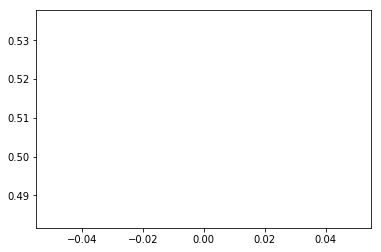

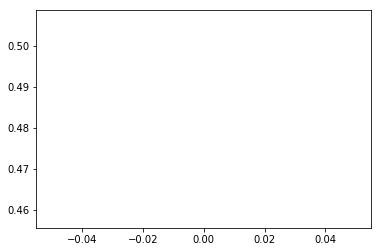

S(a)
[ 0.24834961] [ 0.75165039]
S(e)
[ 0.31905913] [ 0.68094087]
S(f)
[ 0.12555349] [ 0.87444651]
S(g)
[ 0.15005118] [ 0.84994882]
¬S(h)
[ 0.19167292] [ 0.80832708]
F(a, b)
[ 0.33887106] [ 0.66112894]
F(a, e)
[ 0.34596819] [ 0.65403181]
F(a, f)
[ 0.23101544] [ 0.76898456]
F(a, g)
[ 0.83154881] [ 0.16845118]
F(b, c)
[ 0.77167475] [ 0.22832526]
F(c, d)
[ 0.85093266] [ 0.14906733]
F(e, f)
[ 0.20275629] [ 0.79724371]
F(g, h)
[ 0.92248076] [ 0.07751923]
¬F(a, c)
[ 0.46455777] [ 0.53544223]
¬F(a, d)
[ 0.52262181] [ 0.47737819]
¬F(a, h)
[ 0.11279768] [ 0.88720232]
¬F(b, d)
[ 0.11777759] [ 0.88222241]
¬F(b, e)
[ 0.19835365] [ 0.80164635]
¬F(b, f)
[ 0.25446868] [ 0.74553132]
¬F(b, g)
[ 0.17596132] [ 0.82403868]
¬F(c, e)
[ 0.10641247] [ 0.89358753]
¬F(c, f)
[ 0.2805149] [ 0.7194851]
¬F(d, e)
[ 0.10618842] [ 0.89381158]
¬F(d, f)
[ 0.27356815] [ 0.72643185]
¬F(f, g)
[ 0.10736793] [ 0.89263207]
¬C(d)
[ 0.11366123] [ 0.88633877]
S(i)
[ 0.44380242] [ 0.55619758]
S(n)
[ 0.48985904] [ 0.51014096]
¬S(k

  0%|          | 1/2000 [00:02<1:13:42,  2.21s/it]

47


  5%|▌         | 100/2000 [01:39<31:25,  1.01it/s]

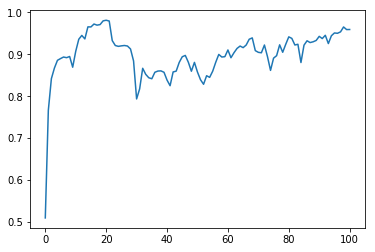

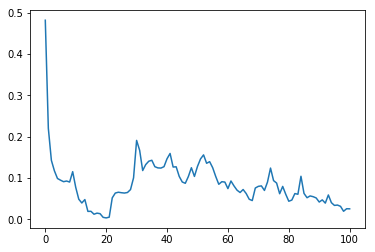

F(a, b)
[ 0.31847763] [ 0.68152237]
F(a, g)
[ 0.99976838] [ 0.00023161]
F(g, h)
[ 0.96983951] [ 0.03016047]
¬F(b, d)
[ 0.12960315] [ 0.87039685]
F(m, n)
[ 0.23549211] [ 0.76450789]
¬F(a, a)
[ 0.12469906] [ 0.00240749]
¬F(b, b)
[ 0.11446588] [ 0.08427298]
¬F(c, c)
[ 0.12499976] [  1.90734863e-06]
¬F(d, d)
[ 0.12117824] [ 0.03057408]
¬F(e, e)
[ 0.12499759] [  1.93119049e-05]
¬F(f, f)
[ 0.12452156] [ 0.00382751]
¬S(f) ∨ C(f)
[ 0.12381952] [ 0.00944387]
¬S(g) ∨ C(g)
[ 0.12347924] [ 0.0121661]
¬F(i, i)
[ 0.16643088] [ 0.00141478]
¬F(j, j)
[ 0.16666548] [  7.15255737e-06]


  5%|▌         | 101/2000 [01:41<31:43,  1.00s/it]

¬S(i) ∨ C(i)
[ 0.13725337] [ 0.17647977]
¬S(n) ∨ C(n)
[ 0.15166917] [ 0.08998495]
17


 10%|█         | 200/2000 [03:28<31:19,  1.04s/it]

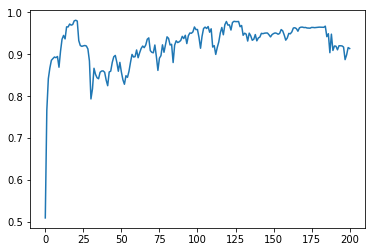

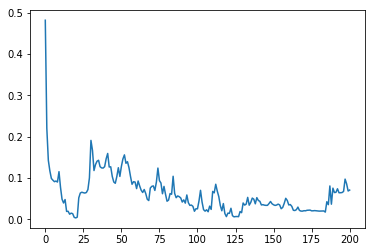

F(b, c)
[ 0.99982065] [ 0.00017937]
F(c, d)
[ 0.99977183] [ 0.00022819]
F(g, h)
[ 0.5013212] [ 0.49867883]
¬F(a, h)
[ 0.34870148] [ 0.65129852]
¬F(d, f)
[ 0.28070331] [ 0.71929669]
¬F(i, n)
[ 0.31155574] [ 0.68844426]
¬F(a, a)
[ 0.12497333] [ 0.00021333]
¬F(e, e)
[ 0.1227153] [ 0.01827759]
¬F(g, g)
[ 0.12447917] [ 0.0041666]
F(b, a) ∨ F(b, b) ∨ F(b, c) ∨ F(b, d) ∨ F(b, e) ∨ F(b, f) ∨ F(b, g) ∨ F(b, h)
[ 0.1248436] [ 0.00125123]
F(c, a) ∨ F(c, b) ∨ F(c, c) ∨ F(c, d) ∨ F(c, e) ∨ F(c, f) ∨ F(c, g) ∨ F(c, h)
[ 0.11828852] [ 0.05369186]
¬S(f) ∨ C(f)
[ 0.12302643] [ 0.01578857]
¬S(g) ∨ C(g)
[ 0.12373482] [ 0.01012146]
¬F(k, k)
[ 0.16662696] [ 0.00023824]
¬F(m, m)
[ 0.16489068] [ 0.010656]
F(j, i) ∨ F(j, j) ∨ F(j, k) ∨ F(j, l) ∨ F(j, m) ∨ F(j, n)
[ 0.16656959] [ 0.00058246]


 10%|█         | 201/2000 [03:30<31:27,  1.05s/it]

¬S(i) ∨ C(i)
[ 0.12462616] [ 0.25224301]
¬S(n) ∨ C(n)
[ 0.10235437] [ 0.38587382]
18


 15%|█▌        | 300/2000 [05:21<30:19,  1.07s/it]

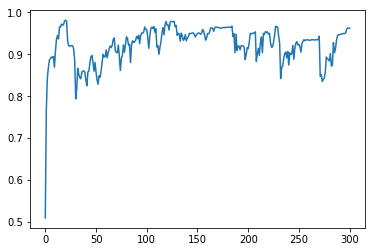

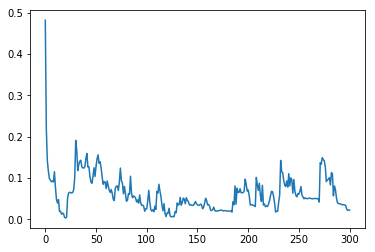

F(b, c)
[ 0.99999434] [  5.69043959e-06]
¬F(a, c)
[ 0.37315619] [ 0.62684381]
¬F(a, a)
[ 0.12494732] [ 0.00042146]
F(d, a) ∨ F(d, b) ∨ F(d, c) ∨ F(d, d) ∨ F(d, e) ∨ F(d, f) ∨ F(d, g) ∨ F(d, h)
[ 0.11676581] [ 0.06587353]
¬S(f) ∨ C(f)
[ 0.1230938] [ 0.01524961]
¬S(g) ∨ C(g)
[ 0.12348179] [ 0.0121457]
F(j, i) ∨ F(j, j) ∨ F(j, k) ∨ F(j, l) ∨ F(j, m) ∨ F(j, n)
[ 0.15957956] [ 0.04252269]
F(l, i) ∨ F(l, j) ∨ F(l, k) ∨ F(l, l) ∨ F(l, m) ∨ F(l, n)
[ 0.13668257] [ 0.17990458]


 15%|█▌        | 301/2000 [05:23<30:24,  1.07s/it]

8


 20%|██        | 400/2000 [07:21<29:25,  1.10s/it]

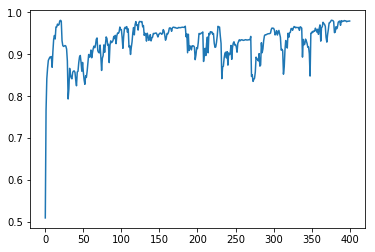

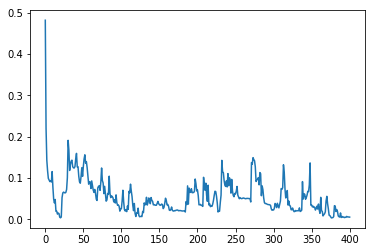

¬F(a, a)
[ 0.11548433] [ 0.07612538]
¬F(c, c)
[ 0.12491099] [ 0.0007121]
¬F(e, e)
[ 0.11330326] [ 0.09357393]
¬S(f) ∨ C(f)
[ 0.1229464] [ 0.01642876]
¬S(g) ∨ C(g)
[ 0.12396841] [ 0.00825275]
¬F(k, k)
[ 0.15060565] [ 0.09636617]
¬F(l, l)
[ 0.14015947] [ 0.15904319]
F(j, i) ∨ F(j, j) ∨ F(j, k) ∨ F(j, l) ∨ F(j, m) ∨ F(j, n)
[ 0.14433925] [ 0.13396454]


 20%|██        | 401/2000 [07:23<29:29,  1.11s/it]

¬S(i) ∨ C(i)
[ 0.10635629] [ 0.36186224]
¬S(n) ∨ C(n)
[ 0.13641553] [ 0.1815069]
10


 25%|██▌       | 500/2000 [09:35<28:45,  1.15s/it]

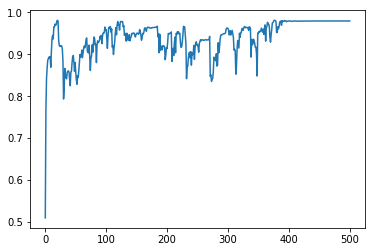

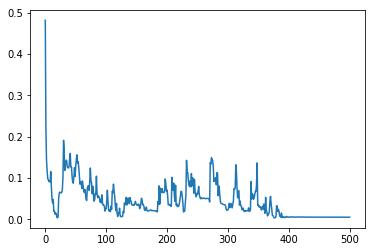

¬F(a, a)
[ 0.12441353] [ 0.00469178]
¬F(c, c)
[ 0.12487671] [ 0.00098634]
¬F(d, d)
[ 0.11385962] [ 0.08912307]
¬F(e, e)
[ 0.10979678] [ 0.12162572]
¬S(f) ∨ C(f)
[ 0.12346432] [ 0.01228544]
¬S(g) ∨ C(g)
[ 0.1239088] [ 0.00872956]
¬F(k, k)
[ 0.14256583] [ 0.14460504]
¬F(l, l)
[ 0.16086991] [ 0.03478056]
F(j, i) ∨ F(j, j) ∨ F(j, k) ∨ F(j, l) ∨ F(j, m) ∨ F(j, n)
[ 0.13303456] [ 0.20179266]


 25%|██▌       | 501/2000 [09:38<28:49,  1.15s/it]

¬S(i) ∨ C(i)
[ 0.13244295] [ 0.20534231]
¬S(n) ∨ C(n)
[ 0.15376842] [ 0.07738951]
11


 30%|███       | 600/2000 [11:28<26:47,  1.15s/it]

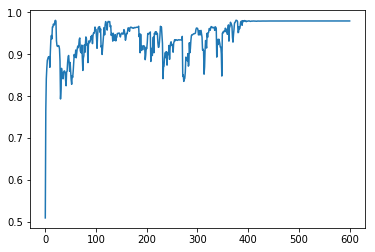

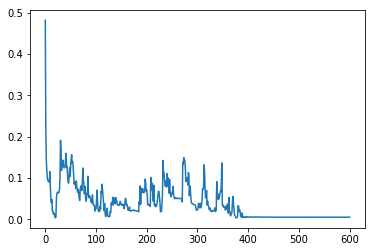

¬F(a, a)
[ 0.12447922] [ 0.00416625]
¬F(c, c)
[ 0.12484846] [ 0.0012123]
¬F(d, d)
[ 0.11804087] [ 0.05567306]
¬F(e, e)
[ 0.10921013] [ 0.12631893]
¬S(f) ∨ C(f)
[ 0.12344375] [ 0.01244998]
¬S(g) ∨ C(g)
[ 0.12391559] [ 0.00867526]
¬F(k, k)
[ 0.14973617] [ 0.10158306]
¬F(l, l)
[ 0.16344169] [ 0.01934993]
F(j, i) ∨ F(j, j) ∨ F(j, k) ∨ F(j, l) ∨ F(j, m) ∨ F(j, n)
[ 0.15160525] [ 0.09036854]


 30%|███       | 601/2000 [11:30<26:48,  1.15s/it]

¬S(i) ∨ C(i)
[ 0.13100675] [ 0.21395956]
¬S(n) ∨ C(n)
[ 0.15292829] [ 0.08243028]
11


 35%|███▌      | 700/2000 [13:16<24:38,  1.14s/it]

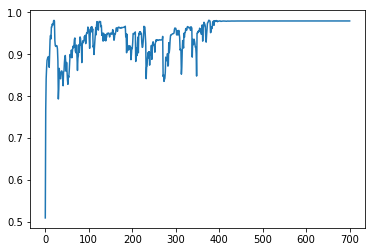

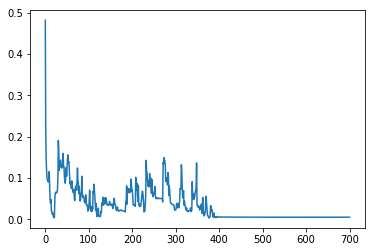

¬F(a, a)
[ 0.1244219] [ 0.00462478]
¬F(c, c)
[ 0.12490296] [ 0.00077629]
¬F(d, d)
[ 0.11934102] [ 0.04527187]
¬F(e, e)
[ 0.10683244] [ 0.1453405]
¬S(f) ∨ C(f)
[ 0.12341346] [ 0.01269235]
¬S(g) ∨ C(g)
[ 0.12391855] [ 0.00865159]
¬F(k, k)
[ 0.15721051] [ 0.05673695]
¬F(l, l)
[ 0.16509986] [ 0.0094009]
F(j, i) ∨ F(j, j) ∨ F(j, k) ∨ F(j, l) ∨ F(j, m) ∨ F(j, n)
[ 0.16229261] [ 0.02624433]


 35%|███▌      | 701/2000 [13:18<24:38,  1.14s/it]

¬S(i) ∨ C(i)
[ 0.13285986] [ 0.20284089]
¬S(n) ∨ C(n)
[ 0.15280819] [ 0.08315084]
11


 40%|████      | 800/2000 [15:08<22:43,  1.14s/it]

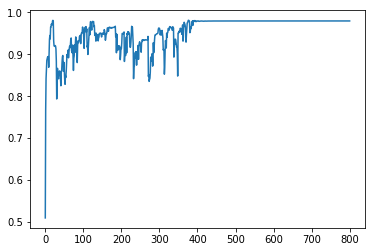

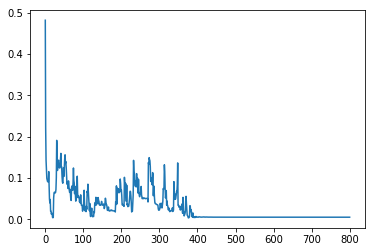

¬F(a, a)
[ 0.12417112] [ 0.00663108]
¬F(c, c)
[ 0.12495337] [ 0.00037301]
¬F(d, d)
[ 0.11560309] [ 0.07517529]
¬F(e, e)
[ 0.10279886] [ 0.17760909]
¬S(f) ∨ C(f)
[ 0.12337931] [ 0.01296558]
¬S(g) ∨ C(g)
[ 0.12392162] [ 0.00862703]
¬F(k, k)
[ 0.16236851] [ 0.02578896]
¬F(l, l)
[ 0.16569661] [ 0.00582039]
F(j, i) ∨ F(j, j) ∨ F(j, k) ∨ F(j, l) ∨ F(j, m) ∨ F(j, n)
[ 0.16520129] [ 0.00879228]
¬S(i) ∨ C(i)

 40%|████      | 801/2000 [15:10<22:43,  1.14s/it]


[ 0.13394827] [ 0.1963104]
¬S(n) ∨ C(n)
[ 0.15316911] [ 0.08098535]
11


 45%|████▌     | 900/2000 [16:50<20:34,  1.12s/it]

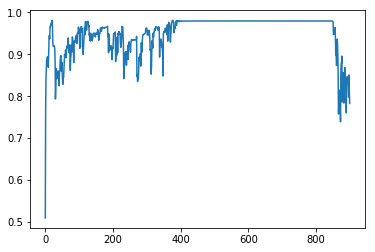

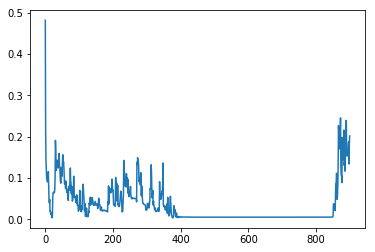

S(e)
[ 0.22787744] [ 0.77212256]
F(a, b)
[ 0.67207408] [ 0.32792592]
F(a, e)
[ 0.96933162] [ 0.03066839]
F(a, f)
[ 0.12882823] [ 0.87117177]
F(a, g)
[ 0.99999481] [  5.21257880e-06]
F(b, c)
[ 0.44833153] [ 0.55166847]
F(c, d)
[ 0.99998707] [  1.29346663e-05]
F(e, f)
[ 0.99999869] [  1.33077469e-06]
F(g, h)
[ 0.99998438] [  1.56091828e-05]
¬F(a, c)
[ 0.96607536] [ 0.03392464]
¬F(b, f)
[ 0.72697341] [ 0.27302659]
¬F(d, f)
[ 0.82420284] [ 0.17579716]
S(n)
[ 0.10205668] [ 0.89794332]
¬S(l)
[ 0.16307068] [ 0.83692932]
¬S(m)
[ 0.19111103] [ 0.80888897]
F(i, m)
[ 0.98879141] [ 0.01120859]
F(k, l)
[ 0.23815483] [ 0.76184517]
¬F(i, k)
[ 0.27444863] [ 0.72555137]
¬F(k, m)
[ 0.33058059] [ 0.66941941]
¬F(l, m)
[ 0.17309463] [ 0.82690537]
¬F(a, a)
[ 0.10796553] [ 0.13627577]
¬F(b, b)
[ 0.11994871] [ 0.04041034]
¬F(f, f)
[ 0.12494928] [ 0.00040573]
F(c, a) ∨ F(c, b) ∨ F(c, c) ∨ F(c, d) ∨ F(c, e) ∨ F(c, f) ∨ F(c, g) ∨ F(c, h)
[ 0.12301175] [ 0.01590597]
F(h, a) ∨ F(h, b) ∨ F(h, c) ∨ F(h, d) ∨ F(h, e)

 45%|████▌     | 901/2000 [16:52<20:34,  1.12s/it]

¬S(i) ∨ C(i)
[ 0.16666488] [  1.07288361e-05]
¬S(n) ∨ C(n)
[ 0.14965722] [ 0.10205668]
34


 50%|█████     | 1000/2000 [18:30<18:30,  1.11s/it]

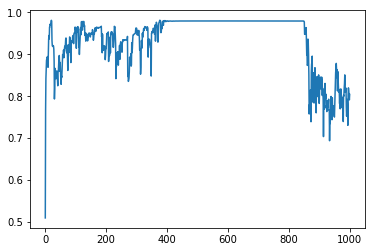

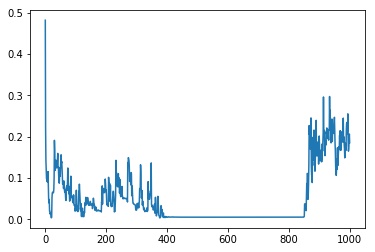

S(f)
[ 0.99999988] [  9.82785551e-08]
S(g)
[ 0.67632914] [ 0.32367086]
F(a, e)
[ 0.21780783] [ 0.78219217]
F(b, c)
[ 0.23993069] [ 0.76006931]
F(c, d)
[ 0.99993128] [  6.87028951e-05]
¬F(a, c)
[ 0.23020256] [ 0.76979744]
¬F(a, d)
[ 0.16211134] [ 0.83788866]
¬F(b, d)
[ 0.78407556] [ 0.21592444]
¬F(b, h)
[ 0.64205825] [ 0.35794175]
¬F(c, f)
[ 0.92285621] [ 0.07714379]
¬F(c, g)
[ 0.70534289] [ 0.29465711]
¬F(e, g)
[ 0.64819932] [ 0.35180068]
¬C(b)
[ 0.11406308] [ 0.88593692]
¬C(g)
[ 0.14460784] [ 0.85539216]
¬S(m)
[ 0.52740669] [ 0.47259331]
F(i, j)
[ 0.27322483] [ 0.72677517]
F(i, m)
[ 0.99944049] [ 0.00055948]
¬F(i, l)
[ 0.99228233] [ 0.00771767]
¬F(i, n)
[ 0.4100222] [ 0.5899778]
¬F(j, l)
[ 0.9999485] [  5.14984131e-05]
¬F(l, n)
[ 0.89623749] [ 0.10376251]
¬F(k, m)
[ 0.96147501] [ 0.03852499]
¬F(l, m)
[ 0.99641585] [ 0.00358415]
¬F(a, a)
[ 0.12414424] [ 0.00684607]
¬F(d, d)
[ 0.11752479] [ 0.0598017]
F(f, a) ∨ F(f, b) ∨ F(f, c) ∨ F(f, d) ∨ F(f, e) ∨ F(f, f) ∨ F(f, g) ∨ F(f, h)
[ 0.1008

 50%|█████     | 1001/2000 [18:32<18:29,  1.11s/it]

¬S(i) ∨ C(i)
[ 0.13534597] [ 0.18792421]
30


 55%|█████▌    | 1100/2000 [20:17<16:36,  1.11s/it]

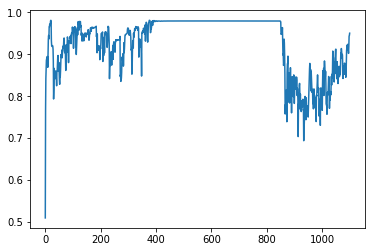

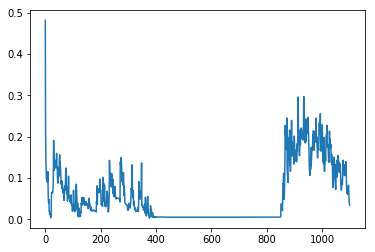

F(b, c)
[ 0.99999958] [  4.01666227e-07]
F(g, h)
[ 0.98115677] [ 0.01884321]
¬F(a, a)
[ 0.12499754] [  1.96695328e-05]
¬F(c, c)
[ 0.12186489] [ 0.02508086]
¬F(d, d)
[ 0.12499863] [  1.09672546e-05]
¬F(g, g)
[ 0.12493528] [ 0.00051773]
F(b, a) ∨ F(b, b) ∨ F(b, c) ∨ F(b, d) ∨ F(b, e) ∨ F(b, f) ∨ F(b, g) ∨ F(b, h)
[ 0.12398534] [ 0.00811727]
¬S(f) ∨ C(f)
[ 0.12379521] [ 0.00963831]
¬S(g) ∨ C(g)
[ 0.12118068] [ 0.03055453]
¬F(i, i)
[ 0.16665876] [  4.74452972e-05]
¬F(j, j)
[ 0.11469035] [ 0.31185794]
¬F(k, k)
[ 0.16665345] [  7.92741776e-05]
¬F(m, m)
[ 0.16666648] [  1.19209290e-06]


 55%|█████▌    | 1101/2000 [20:19<16:35,  1.11s/it]

¬S(n) ∨ C(n)
[ 0.16346329] [ 0.01922027]
14


 60%|██████    | 1200/2000 [22:15<14:50,  1.11s/it]

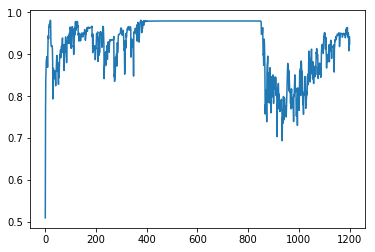

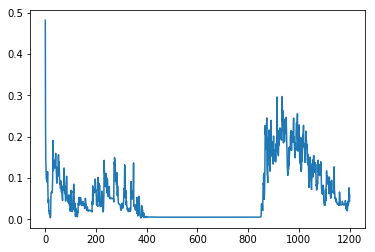

F(c, d)
[ 0.82447672] [ 0.17552328]
F(g, h)
[ 0.98646051] [ 0.01353948]
¬F(a, c)
[ 0.99987137] [ 0.00012863]
¬F(a, a)
[ 0.12498672] [ 0.00010622]
¬F(c, c)
[ 0.12499669] [  2.64644623e-05]
¬F(e, e)
[ 0.1188665] [ 0.04906797]
¬F(g, g)
[ 0.11437941] [ 0.08496469]
¬S(f) ∨ C(f)
[ 0.1235984] [ 0.01121277]
¬S(g) ∨ C(g)
[ 0.12346346] [ 0.01229233]
¬F(k, k)
[ 0.14944983] [ 0.10330111]
¬F(l, l)
[ 0.1474272] [ 0.11543685]
¬F(m, m)
[ 0.16641225] [ 0.00152653]
F(j, i) ∨ F(j, j) ∨ F(j, k) ∨ F(j, l) ∨ F(j, m) ∨ F(j, n)
[ 0.15890221] [ 0.04658677]


 60%|██████    | 1201/2000 [22:17<14:49,  1.11s/it]

¬S(n) ∨ C(n)
[ 0.13596836] [ 0.18418989]
14


 65%|██████▌   | 1300/2000 [24:04<12:57,  1.11s/it]

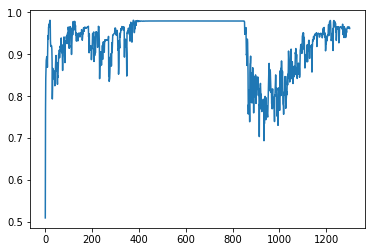

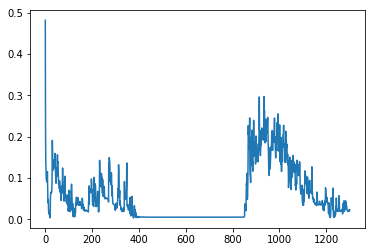

F(a, g)
[ 0.99948817] [ 0.00051184]
¬F(c, c)
[ 0.12499575] [  3.39746475e-05]
¬F(d, d)
[ 0.12241368] [ 0.02069056]
¬F(e, e)
[ 0.12490933] [ 0.00072533]
¬F(f, f)
[ 0.12476417] [ 0.00188661]
¬F(g, g)
[ 0.1249837] [ 0.00013041]
¬F(h, h)
[ 0.1157227] [ 0.07421839]
¬S(f) ∨ C(f)
[ 0.1224423] [ 0.02046163]
¬S(g) ∨ C(g)
[ 0.12437198] [ 0.00502419]
¬F(k, k)
[ 0.16638173] [ 0.00170964]
¬F(l, l)
[ 0.1652133] [ 0.00872022]
¬F(m, m)
[ 0.16580065] [ 0.00519615]
F(j, i) ∨ F(j, j) ∨ F(j, k) ∨ F(j, l) ∨ F(j, m) ∨ F(j, n)
[ 0.16214609] [ 0.02712349]


 65%|██████▌   | 1301/2000 [24:06<12:56,  1.11s/it]

¬S(n) ∨ C(n)
[ 0.15325767] [ 0.08045397]
14


 70%|███████   | 1400/2000 [25:57<11:07,  1.11s/it]

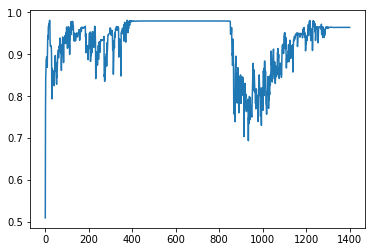

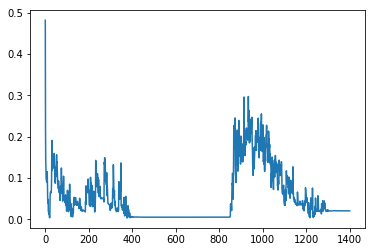

F(a, g)
[ 0.999367] [ 0.000633]
¬F(a, a)
[ 0.1196202] [ 0.04303837]
¬F(c, c)
[ 0.12482759] [ 0.00137925]
¬F(d, d)
[ 0.10609442] [ 0.15124464]
¬F(e, e)
[ 0.12439179] [ 0.00486571]
¬F(h, h)
[ 0.12226211] [ 0.0219031]
¬S(f) ∨ C(f)
[ 0.12311] [ 0.01511995]
¬S(g) ∨ C(g)
[ 0.12364019] [ 0.01087848]
¬F(k, k)
[ 0.16539374] [ 0.00763762]
¬F(l, l)
[ 0.16503721] [ 0.00977677]
¬F(m, m)
[ 0.15993848] [ 0.04036915]
F(j, i) ∨ F(j, j) ∨ F(j, k) ∨ F(j, l) ∨ F(j, m) ∨ F(j, n)
[ 0.16435] [ 0.01389997]


 70%|███████   | 1401/2000 [25:59<11:06,  1.11s/it]

¬S(n) ∨ C(n)
[ 0.15905868] [ 0.04564798]
13


 75%|███████▌  | 1500/2000 [28:00<09:20,  1.12s/it]

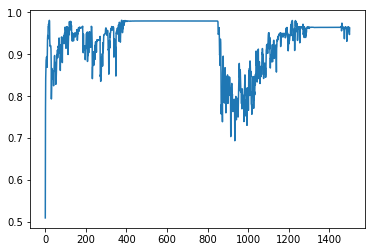

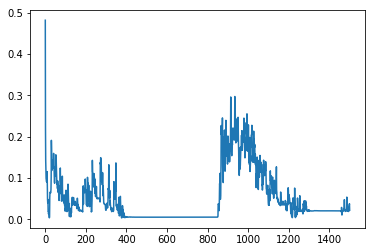

F(a, g)
[ 0.99993199] [  6.80077137e-05]
¬F(c, h)
[ 0.96226901] [ 0.03773099]
¬F(a, a)
[ 0.10487366] [ 0.16101068]
¬F(c, c)
[ 0.1249634] [ 0.00029284]
¬F(e, e)
[ 0.12436203] [ 0.00510377]
¬F(f, f)
[ 0.12356112] [ 0.01151103]
¬F(g, g)
[ 0.12490056] [ 0.00079554]
¬S(f) ∨ C(f)
[ 0.12295189] [ 0.01638483]
¬S(g) ∨ C(g)
[ 0.12438127] [ 0.00494987]
¬F(k, k)
[ 0.16617021] [ 0.00297874]
¬F(l, l)
[ 0.16637491] [ 0.00175059]
F(j, i) ∨ F(j, j) ∨ F(j, k) ∨ F(j, l) ∨ F(j, m) ∨ F(j, n)
[ 0.14801177] [ 0.11192936]


 75%|███████▌  | 1501/2000 [28:02<09:19,  1.12s/it]

¬S(n) ∨ C(n)
[ 0.13287118] [ 0.20277299]
13


 80%|████████  | 1600/2000 [29:45<07:26,  1.12s/it]

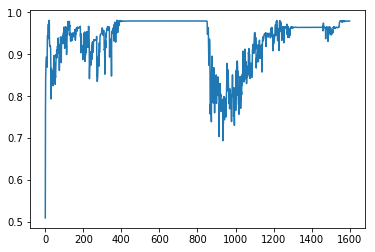

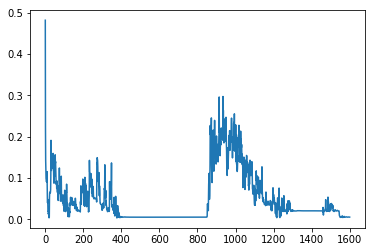

¬F(a, a)
[ 0.12481727] [ 0.00146186]
¬F(c, c)
[ 0.12497217] [ 0.00022262]
¬F(e, e)
[ 0.11364224] [ 0.0908621]
¬F(g, g)
[ 0.12455317] [ 0.00357467]
¬S(f) ∨ C(f)
[ 0.12328435] [ 0.01372525]
¬S(g) ∨ C(g)
[ 0.12406497] [ 0.00748026]
¬F(k, k)
[ 0.16426274] [ 0.01442355]
¬F(l, l)
[ 0.16540104] [ 0.00759381]
¬F(m, m)
[ 0.16113698] [ 0.03317809]
F(j, i) ∨ F(j, j) ∨ F(j, k) ∨ F(j, l) ∨ F(j, m) ∨ F(j, n)
[ 0.16498365] [ 0.01009815]


 80%|████████  | 1601/2000 [29:47<07:25,  1.12s/it]

¬S(n) ∨ C(n)
[ 0.15491182] [ 0.07052911]
11


 85%|████████▌ | 1700/2000 [31:42<05:35,  1.12s/it]

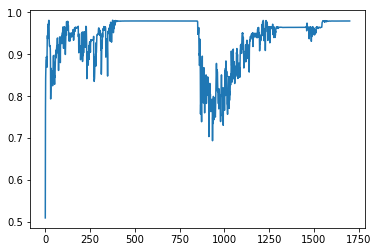

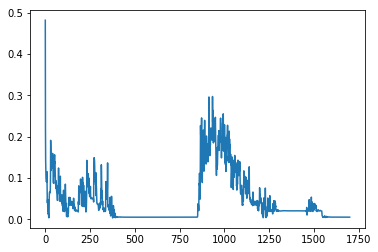

¬F(a, a)
[ 0.1249176] [ 0.00065917]
¬F(c, c)
[ 0.12498361] [ 0.00013113]
¬F(e, e)
[ 0.10482291] [ 0.16141671]
¬F(g, g)
[ 0.10958777] [ 0.12329787]
¬S(f) ∨ C(f)
[ 0.12327087] [ 0.01383303]
¬S(g) ∨ C(g)
[ 0.12405206] [ 0.00758354]
¬F(k, k)
[ 0.16086991] [ 0.03478056]
¬F(l, l)
[ 0.16443504] [ 0.01338977]
¬F(m, m)
[ 0.136416] [ 0.18150401]
F(j, i) ∨ F(j, j) ∨ F(j, k) ∨ F(j, l) ∨ F(j, m) ∨ F(j, n)
[ 0.16414332] [ 0.01514013]


 85%|████████▌ | 1701/2000 [31:45<05:34,  1.12s/it]

¬S(n) ∨ C(n)
[ 0.15048596] [ 0.09708429]
11


 90%|█████████ | 1800/2000 [33:30<03:43,  1.12s/it]

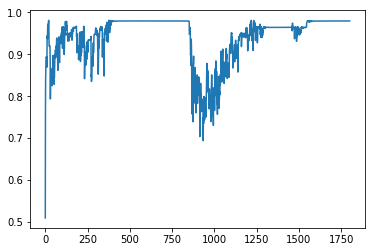

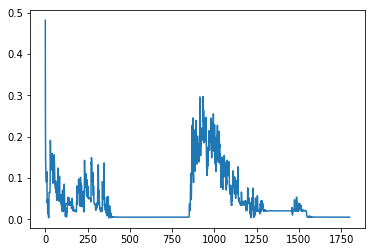

¬F(a, a)
[ 0.12494952] [ 0.00040382]
¬F(c, c)
[ 0.12483272] [ 0.00133824]
¬F(e, e)
[ 0.10900616] [ 0.12795073]
¬F(g, g)
[ 0.11435849] [ 0.08513206]
¬S(f) ∨ C(f)
[ 0.12320622] [ 0.01435024]
¬S(g) ∨ C(g)
[ 0.12410939] [ 0.00712488]
¬F(k, k)
[ 0.15487352] [ 0.07075888]
¬F(l, l)
[ 0.16077566] [ 0.03534609]
F(j, i) ∨ F(j, j) ∨ F(j, k) ∨ F(j, l) ∨ F(j, m) ∨ F(j, n)
[ 0.16181812] [ 0.02909135]


 90%|█████████ | 1801/2000 [33:32<03:42,  1.12s/it]

¬S(n) ∨ C(n)
[ 0.14813967] [ 0.11116201]
10


 92%|█████████▏| 1838/2000 [34:23<03:01,  1.12s/it]

KeyboardInterrupt: 

In [90]:
kb_train2=kb1.union(kb2).union(gkb1).union(gkb2)
ltn2=LTN(emb_dim,'abcdefghijklmn',[['S',1],['F',2],['C',1]])
optimizor=torch.optim.Adam(ltn2.parameters(),lr=0.1,weight_decay=0.1)
mone=torch.FloatTensor([-1])
one=torch.FloatTensor([1])
average_prob2=[]
average_loss2=[]
for i in tqdm(range(2000)):
    optimizor.zero_grad()
    total_probability=0.0
    total_loss=0.0
    for clause in kb_train.clauses:
        loss,prob=ltn2.forward(clause=clause)
        loss.backward(one)
        total_probability+=prob.data.numpy()[0]
        total_loss+=loss.data.numpy()[0]
    optimizor.step()
    average_prob2.append(total_probability/len(kb_train.clauses))
    average_loss2.append(total_loss/len(kb_train.clauses))
    if i%100==0:
        plt.plot(average_prob2)
        plt.show()
        plt.plot(average_loss2)
        plt.show()
        show_results(ltn2,kb_train2)

In [78]:
show_results(ltn1,kb2)

F(i, m)
[ 0.40392089] [ 0.59607911]
F(k, l)
[ 0.90495288] [ 0.09504712]
F(m, n)
[ 0.94120848] [ 0.05879149]
¬F(i, k)
[ 0.35173821] [ 0.64826179]
4


In [52]:
import pandas as pd
import numpy

In [53]:
def get_DF_S(model,constants):
    constants=list(constants)
    df=pd.DataFrame(index=constants,columns=['S'])
    for a in constants:
        clause=Clause(1,1,[Predicate(name='S',variables=[a],negation=False)])
        result=model.forward(clause)
        df['S'][a]='%0.2f'%result[1].data.numpy()[0]
    return df

In [54]:
def get_DF_C(model,constants):
    constants=list(constants)
    df=pd.DataFrame(index=constants,columns=['C'])
    for a in constants:
        clause=Clause(1,1,[Predicate(name='C',variables=[a],negation=False)])
        result=model.forward(clause)
        df['C'][a]='%0.2f'%result[1].data.numpy()[0]
    return df

In [55]:
def get_DF_F(model,constants):
    constants=list(constants)
    df=pd.DataFrame(index=constants, columns=constants)
    for a in constants:
        for b in constants:
#             if a>=b:
#                 df[b][a]='-'
#                 continue
            clause=Clause(1,1,[Predicate(name='F',variables=[a,b],negation=False)])
            result=model.forward(clause)
            df[b][a]='%0.2f'%result[1].data.numpy()[0]
    return df

In [56]:
def get_DF(model,constants):
    df1=get_DF_S(model,constants)
    df2=get_DF_C(model,constants)
    df3=get_DF_F(model,constants)
    df=pd.concat([df1,df2,df3],axis=1)
    return df

In [80]:
show_results(ltn2,kb1)

0


In [81]:
show_results(ltn2,kb2)

0


In [82]:
get_DF(ltn1,'abcdefgh')

,S,C,a,b,c,d,e,f,g,h
a,0.98,0.99,0.93,0.97,0.36,0.20,0.46,0.39,0.23,0.04
b,0.00,0.00,0.03,0.17,0.03,0.00,0.01,0.02,0.00,0.00
c,0.00,0.00,0.01,0.14,0.00,0.01,0.01,0.01,0.00,0.00
d,0.00,0.00,0.00,0.04,0.00,0.00,0.01,0.00,0.00,0.00
e,1.00,0.99,0.29,0.69,0.09,0.07,0.04,0.10,0.03,0.02
f,1.00,0.00,0.01,0.09,0.00,0.02,0.00,0.02,0.00,0.00
g,1.00,0.00,0.98,0.84,0.34,0.13,0.01,0.11,0.02,0.01
h,0.00,0.00,0.15,0.32,0.03,0.01,0.00,0.08,0.00,0.00


In [62]:
get_DF(ltn1,'ijklmn')

,S,C,i,j,k,l,m,n
i,1.00,0.99,0.94,0.99,0.35,0.03,0.60,0.06
j,0.01,0.99,0.00,0.01,0.00,0.00,0.00,0.00
k,0.00,0.08,0.06,0.22,0.00,0.10,0.00,0.15
l,0.00,0.00,0.00,0.02,0.00,0.01,0.00,0.00
m,0.00,0.47,0.66,0.97,0.06,0.23,0.01,0.06
n,1.00,0.33,0.22,1.00,0.01,0.01,0.02,0.00


In [91]:
get_DF(ltn2,'abcdefgh')

,S,C,a,b,c,d,e,f,g,h
a,0.99,0.99,1.00,1.00,0.00,0.00,1.00,1.00,0.99,0.00
b,0.00,0.01,0.00,0.00,0.99,0.01,0.00,0.00,0.00,0.00
c,0.00,0.01,0.00,0.83,1.00,0.99,0.00,0.00,0.00,0.01
d,0.01,0.01,0.00,0.00,1.00,0.12,0.00,0.00,0.00,0.00
e,1.00,0.98,0.95,0.96,0.00,0.01,0.88,1.00,0.01,0.00
f,0.99,0.01,0.12,0.48,0.13,0.06,0.12,0.28,0.00,0.00
g,0.99,0.01,0.58,1.00,1.00,0.99,0.71,0.96,0.94,0.99
h,0.01,0.01,0.00,0.25,1.00,0.94,0.01,0.01,0.01,0.56


In [84]:
get_DF(ltn2,'ijklmn')

,S,C,i,j,k,l,m,n
i,0.99,0.06,0.01,1.00,0.01,0.00,0.99,0.00
j,0.01,0.02,0.01,0.69,0.00,0.00,0.00,0.01
k,0.01,0.12,0.18,0.01,0.82,0.99,0.00,0.35
l,0.01,0.03,0.01,0.01,0.16,0.66,0.00,0.00
m,0.01,0.02,0.97,0.46,0.46,0.94,0.00,0.99
n,0.99,0.03,0.00,0.93,0.09,0.04,0.83,0.00


In [93]:
def get_accuracy(model,kb):
    results=[]
    for clause in kb.clauses:
        o1,o2=model.forward(clause)
        if o2.data.numpy()[0][0]>0.9:
            results.append(1.0)
        else:
            results.append(0.0)

    return sum(results)/len(kb.clauses)

In [88]:
def show_learned_propositionals(model,propositionals):
    results=pd.DataFrame(index=range(len(propositionals)),columns=['Propositional','Group1','Group2'])
    for i,propositional in enumerate(propositionals):
        total=0
        true_count=0
        kkk1=propositional.generate_knowledge_base('abcdefgh')
        kkk2=propositional.generate_knowledge_base('ijklmn')
        a1=get_accuracy(model,kkk1)
        a2=get_accuracy(model,kkk2)
        results.iloc[i]=dict(Propositional=propositional.clause.show(),Group1=a1,Group2=a2)
    return results

In [67]:
show_learned_propositionals(ltn1,propositionals)

,Propositional,Group1,Group2
0,"¬F(x, x)",[0.850657],[0.839119]
1,"¬F(x, y) ∨ F(y, x)",[0.885901],[0.850276]
2,"F(x, y)",[0.426099],[0.533432]
3,"¬S(x) ∨ ¬F(x, y) ∨ S(y)",[0.938201],[0.915728]
4,¬S(x) ∨ C(x),[0.748311],[0.883699]


In [94]:
show_learned_propositionals(ltn2,propositionals)

,Propositional,Group1,Group2
0,"¬F(x, x)",0.125,0.166667
1,"¬F(x, y) ∨ F(y, x)",0.671875,0.722222
2,"F(x, y)",0.875,0.833333
3,"¬S(x) ∨ ¬F(x, y) ∨ S(y)",0.875,0.833333
4,¬S(x) ∨ C(x),0.75,0.666667


In [265]:
class Test(nn.Module):
    def __init__(self):
        super(Test, self).__init__()
        self.W=nn.Parameter(torch.randn(10, 10, 10))
    def forward(self, embs, negation):
        pass

In [295]:
a=nn.Bilinear(20,20,10,bias=False)

In [298]:
input1=Variable(torch.randn(1, 20))
input2=Variable(torch.randn(1, 20))
a(input1,input2)

Variable containing:
-2.8624  0.1028 -0.7835  2.1155 -0.1974  2.5639  4.0751  0.9362 -6.3984  0.9882
[torch.FloatTensor of size 1x10]